In [17]:
import numpy as np
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import pandas as pd
from pybt.tools.plotters import *
from madxtools.plot_tool import *

In [18]:
T = 23.08 # GeV kinetic energy
# T = 4.54 # GeV kinetic energy ion equivalent of 750 MeV/u
E0 = 0.938 # GeV/c^2 proton rest mass
E = T + E0 # total energy
gamma = E / E0 # gamma
beta = np.sqrt(1-gamma**(-2))
p = E*beta # GeV/c beam momentum

print(f"gamma = {round(gamma,3)}")
print(f"beta = {round(beta,3)}")
print(f"p = {round(p,3)} GeV/c")

gamma = 25.606
beta = 0.999
p = 24.0 GeV/c


In [19]:
def manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, L, scattering=False):
    """
    This function manipulates the global variables of a MADX instance and returns the new beta functions and emittance.
    If the scattering parameter is set to True, it also calculates the new emittance due to scattering.

    Parameters:
    madx (cpymad.madx.Madx): An instance of the MADX class.
    exn (float): The normalized horizontal emittance.
    eyn (float): The normalized vertical emittance.
    p (float): The momentum of the beam.
    beta (float): The relativistic beta factor.
    gamma (float): The relativistic gamma factor.
    L (float): The length of the air region.
    scattering (bool): A boolean indicating whether to calculate the new emittance due to scattering.

    Returns:
    betx0 (float): The new horizontal beta function.
    bety0 (float): The new vertical beta function.
    alfx0 (float): The new horizontal alpha function.
    alfy0 (float): The new vertical alpha function.
    dx0 (float): The new horizontal dispersion.
    dy0 (float): The new vertical dispersion.
    dpx0 (float): The new horizontal momentum deviation.
    dpy0 (float): The new vertical momentum deviation.
    exn (float): The new horizontal emittance.
    eyn (float): The new vertical emittance.
    """

    madx.globals['betx0'] = 'savebeta_air->betx'
    madx.globals['bety0'] = 'savebeta_air->bety'
    madx.globals['alfx0'] = 'savebeta_air->alfx'
    madx.globals['alfy0'] = 'savebeta_air->alfy'
    madx.globals['dx0'] = 'savebeta_air->dx'
    madx.globals['dy0'] = 'savebeta_air->dy'
    madx.globals['dpx0'] = 'savebeta_air->dpx'
    madx.globals['dpy0'] = 'savebeta_air->dpy'

    if scattering==True:
        
        epsilon_0 = exn/(beta*gamma)
        epsilon_0_V = eyn/(beta*gamma)

        p_MeV = p*1000 # Beam total energy in MeV
        q = 1
        P = 1.01325 # Standard air pressure at sea level in Bar
        P_Torr = P*750.062 # Standard air pressure at sea level in Torr
        L_rad0 = 301 # For air. Table with radiation lengths: https://cds.cern.ch/record/941314/files/p245.pdf
        L_rad = L_rad0/(P_Torr/760)

        theta_rms = (13.6/p_MeV*beta)*q*np.sqrt(L/L_rad)

        # Horizontal
        gamma0 = (1 + madx.globals['alfx0']**2) / madx.globals['betx0']
        Delta_epsilon = (1/2)*theta_rms**2*(madx.globals['betx0'] + L*madx.globals['alfx0'] + (L**2/3)*gamma0)
        epsilon_1 = epsilon_0 + Delta_epsilon
        alfx0_1 = (epsilon_0*madx.globals['alfx0'] - (L/2)*theta_rms**2 ) / (epsilon_0 + Delta_epsilon)
        betx0_1 = (epsilon_0*madx.globals['betx0'] + (L**2/3)*theta_rms**2 ) / (epsilon_0 + Delta_epsilon)

        # Vertical
        gamma0_V = (1 + madx.globals['alfy0']**2) / madx.globals['bety0']
        Delta_epsilon_V = (1/2)*theta_rms**2*(madx.globals['bety0'] + L*madx.globals['alfy0'] + (L**2/3)*gamma0_V)
        epsilon_1_V = epsilon_0_V + Delta_epsilon_V
        alfy0_1 = (epsilon_0_V*madx.globals['alfy0'] - (L/2)*theta_rms**2 ) / (epsilon_0_V + Delta_epsilon_V)
        bety0_1 = (epsilon_0_V*madx.globals['bety0'] + (L**2/3)*theta_rms**2 ) / (epsilon_0_V + Delta_epsilon_V)

        # Return
        exn = epsilon_1*beta*gamma
        eyn = epsilon_1_V*beta*gamma
        betx0 = betx0_1
        alfx0 = alfx0_1
        bety0 = bety0_1
        alfy0 = alfy0_1
        
    else:
        betx0 = madx.globals['betx0']
        alfx0 = madx.globals['alfx0']
        bety0 = madx.globals['bety0']
        alfy0 = madx.globals['alfy0']
    
    dx0 = madx.globals['dx0']
    dy0 = madx.globals['dy0']
    dpx0 = madx.globals['dpx0']
    dpy0 = madx.globals['dpy0']

    return betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn

In [20]:
def add_air_region(madx, title, sequence, air_start_pos, air_stop_pos, steps):
    """
    This function adds an air region to the MADX sequence.

    Parameters:
    madx (cpymad.madx.Madx): An instance of the MADX class.
    air_start_pos (float): The starting position of the air region.
    air_stop_pos (float): The stopping position of the air region.
    steps (float): The distance between two consecutive inner markers.

    Returns:
    None
    """

    # Calculate the positions of the inner markers
    inner_marker_array = np.arange(air_start_pos+steps, air_stop_pos, steps)

    # Add the markers for the start and end of the air region
    madx.input(f'''
    AIR_START : MARKER;
    AIR_END : MARKER;
    ''')           

    # Install the markers for the start and end of the air region
    madx.input(f'''
    SEQEDIT, SEQUENCE={sequence};
    INSTALL, ELEMENT=AIR_START, CLASS=AIR_START, AT={air_start_pos};
    INSTALL, ELEMENT=AIR_END, CLASS=AIR_END, AT={air_stop_pos};
    ENDEDIT;
    ''')

    # Add the inner markers
    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    # Create a for loop for the inner markers:
    for count, pos in enumerate(inner_marker_array):
        madx.input(f"INSTALL, ELEMENT=INNER_MARKER{str(count)}_{title}, CLASS=MARKER, AT={pos};")
        # print(f"INNER_MARKER{str(count)}")
    madx.input("ENDEDIT;")

    # Add marker at the end of the line to see the evolution of the beam with fine resolution
    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    for count, pos in enumerate(np.arange(20, 100, 1)):
        madx.input(f"INSTALL, ELEMENT=HIDDEN_MARKER{str(count)}, CLASS=MARKER, AT={pos};")
    madx.input("ENDEDIT;")

    return

In [21]:
# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

ex = exn/(beta*gamma)
ex_initial = ex
ey = eyn/(beta*gamma)
ey_initial = ey

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input('''

QF : QUADRUPOLE, L = 2, APERTYPE=CIRCLE, APERTURE={0.025};
QD : QUADRUPOLE, L = 2, APERTYPE=CIRCLE, APERTURE={0.025};

QF1 : QF, K1 := kQF1;
QD2 : QD, K1 := kQD2;
QF3 : QF, K1 := kQF3;
QD4 : QD, K1 := kQD4;

kQF1 = 0.32730047;
kQD2 = -0.36102915;
kQF3 = 0.32789126;
kQD4 = -0.1991137;

simple_seq: SEQUENCE, refer = exit, l = 100;
QF1 : QF1, AT=2;
QD2 : QD2, AT=5;
QF3 : QF3, AT=8;
QD4 : QD4, AT=11;
END : MARKER, AT=100;
ENDSEQUENCE;
''')

madx.command.beam(particle='PROTON',pc=p,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
steps = 1
sequence = "simple_seq"
add_air_region(madx, "1", sequence, 20, 30, steps)
add_air_region(madx, "2", sequence, 40, 50, steps)
add_air_region(madx, "3", sequence, 60, 70, steps)

madx.use(sequence=sequence)
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
plot_graph(twiss, ex, sige, ey)


In [22]:
air_start_elements = [name for name in twiss.name if "air_start" in name]
print(f"There are {len(air_start_elements)} air regions in the sequence: {air_start_elements}")

air_start_numbers = [int(name.split(':')[1]) for name in air_start_elements]
print(f"The air regions are numbered: {air_start_numbers}")

There are 3 air regions in the sequence: ['air_start:1', 'air_start:2', 'air_start:3']
The air regions are numbered: [1, 2, 3]


In [23]:
inner_elements = [name for name in twiss.name if "inner" in name]
print(f"There are {len(inner_elements)} inner markers in the sequence")
inner_elements = [name for name in twiss.name if "inner" in name]
for i in range(len(air_start_elements)):
    list = [name for name in inner_elements if name.endswith(f"{str(i+1)}:1")]
    print(list)
    # for inner_marker in list:
    #     print(inner_marker)
    
    print("")

There are 27 inner markers in the sequence
['inner_marker0_1:1', 'inner_marker1_1:1', 'inner_marker2_1:1', 'inner_marker3_1:1', 'inner_marker4_1:1', 'inner_marker5_1:1', 'inner_marker6_1:1', 'inner_marker7_1:1', 'inner_marker8_1:1']

['inner_marker0_2:1', 'inner_marker1_2:1', 'inner_marker2_2:1', 'inner_marker3_2:1', 'inner_marker4_2:1', 'inner_marker5_2:1', 'inner_marker6_2:1', 'inner_marker7_2:1', 'inner_marker8_2:1']

['inner_marker0_3:1', 'inner_marker1_3:1', 'inner_marker2_3:1', 'inner_marker3_3:1', 'inner_marker4_3:1', 'inner_marker5_3:1', 'inner_marker6_3:1', 'inner_marker7_3:1', 'inner_marker8_3:1']



In [24]:
def process_scattering(madx, exn, eyn, beta, gamma, sequence, end, steps, air_start_numbers):

    def update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list):
        madx.command.beam(ex=exn/(beta*gamma), ey=eyn/(beta*gamma))
        ex_list.append(madx.sequence[sequence].beam.ex)
        ey_list.append(madx.sequence[sequence].beam.ey)
        return madx, ex_list, ey_list

    def append_twiss_to_list(madx, sequence, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0):
        madx.use(sequence=sequence)
        twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
        twiss_list.append(twiss)
        return twiss_list

    twiss_list = []
    ex_list = []
    ey_list = []

    betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=False, L=steps)

    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    madx.input(f"EXTRACT, SEQUENCE = {sequence}, FROM=AIR_START, TO={end}, NEWNAME=seq_air_start_to_end;")
    madx.input("ENDEDIT;")

    previous_seq_name = "seq_air_start_to_end"

    # Iterating over all air regions
    for air_region_number in air_start_numbers:
        print(f"Entering air region {air_region_number}")

        inner_marker_list = [name for name in inner_elements if name.endswith(f"{air_region_number}:1")]
        for i in range(len(inner_marker_list)):

            madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)

            print(f"SAVEBETA at INNER_MARKER{str(i)}_{str(air_region_number)}")
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = INNER_MARKER{str(i)}_{str(air_region_number)}, SEQUENCE={previous_seq_name};")
            twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
            betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=steps)

            print(f"Extracting from INNER_MARKER{str(i)}_{str(air_region_number)} to {end}")
            madx.input(f"SEQEDIT, SEQUENCE = {previous_seq_name};")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=INNER_MARKER{str(i)}_{str(air_region_number)}, TO={end}, NEWNAME=seq_inner_marker{str(i)}_to_end;")
            madx.input("ENDEDIT;")

            previous_seq_name = f"seq_inner_marker{str(i)}_to_end"
        
        madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)

        print(f"SAVEBETA at AIR_END")
        
        if air_region_number == 0:
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_END, SEQUENCE={previous_seq_name};")
        else:
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_END[{str(air_region_number)}], SEQUENCE={previous_seq_name};")

        twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
        betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=steps)
        
        madx.input(f"SEQEDIT, SEQUENCE = {previous_seq_name};")
        if air_region_number == 1:
            print(f"Extracting from AIR_END to {end}")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=AIR_END, TO={end}, NEWNAME=seq_air_end_to_end;")
        else:
            print(f"Extracting from AIR_END[{str(air_region_number)}] to {end}")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=AIR_END, TO={end}, NEWNAME=seq_air_end{str(air_region_number)}_to_end;")
        madx.input("ENDEDIT;")

        
        if air_region_number == 1:
            previous_seq_name = f"seq_air_end_to_end"
        else:
            previous_seq_name = f"seq_air_end{str(air_region_number)}_to_end"

        twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
        madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)

    return twiss_list, ex_list, ey_list

madx.use(sequence=sequence)
madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
twiss_list, ex_list, ey_list = process_scattering(madx, exn, eyn, beta, gamma, sequence, "end", steps, air_start_numbers)

Entering air region 1
SAVEBETA at INNER_MARKER0_1
Extracting from INNER_MARKER0_1 to end
SAVEBETA at INNER_MARKER1_1
Extracting from INNER_MARKER1_1 to end
SAVEBETA at INNER_MARKER2_1
Extracting from INNER_MARKER2_1 to end
SAVEBETA at INNER_MARKER3_1
Extracting from INNER_MARKER3_1 to end
SAVEBETA at INNER_MARKER4_1
Extracting from INNER_MARKER4_1 to end
SAVEBETA at INNER_MARKER5_1
Extracting from INNER_MARKER5_1 to end
SAVEBETA at INNER_MARKER6_1
Extracting from INNER_MARKER6_1 to end
SAVEBETA at INNER_MARKER7_1
Extracting from INNER_MARKER7_1 to end
SAVEBETA at INNER_MARKER8_1
Extracting from INNER_MARKER8_1 to end
SAVEBETA at AIR_END
Extracting from AIR_END to end
Entering air region 2
SAVEBETA at INNER_MARKER0_2
Extracting from INNER_MARKER0_2 to end
SAVEBETA at INNER_MARKER1_2
Extracting from INNER_MARKER1_2 to end
SAVEBETA at INNER_MARKER2_2
Extracting from INNER_MARKER2_2 to end
SAVEBETA at INNER_MARKER3_2
Extracting from INNER_MARKER3_2 to end
SAVEBETA at INNER_MARKER4_2
Extrac

In [25]:
# Shift the s position so that is is coherent.
for i in range(len(twiss_list)):
    twiss_list[i].s = twiss_list[i].s + twiss.loc[twiss_list[i].iloc[1].name].s

# Plot the results
fig, ax = plt.subplots(2,1, figsize=(12, 4), sharex=True, height_ratios=[1, 4])    

draw_synoptic(ax[0], twiss)
ax[1].plot(twiss.s, twiss.betx)

for i in range(len(twiss_list)):
    ax[1].plot(twiss_list[i].s, twiss_list[i].betx, label=f"twiss {i}")

# ax[1].legend()
ax[1].set_xlabel("s [m]")
ax[1].set_ylabel("betx [m]")

Text(0, 0.5, 'betx [m]')

In [26]:
# We add the emittances to each twiss table
twiss['ex'] = ex_initial

for i in range(len(twiss_list)):
    twiss_list[i]['ex'] = ex_list[i]

twiss['ey'] = ey_initial

for i in range(len(twiss_list)):
    twiss_list[i]['ey'] = ey_list[i]


In [27]:
# We remove the drifts as they are duplicated names
def remove_drift_rows(df):
    df = df.loc[~df.index.str.startswith('drift')]
    df = df.loc[~df.index.str.startswith('#s')]
    return df

twiss_list = [remove_drift_rows(df) for df in twiss_list]

# We combine all the twiss tables into one
def add_missing_rows(df1, df2):
    # Find rows in df1 with lower 's' than the minimum 's' in df2
    missing_rows = df1[df1['s'] < df2['s'].min()]
    
    # Append these rows to df2 and sort by 's'
    df2_updated = pd.concat([df2, missing_rows]).sort_values(by='s')

    return df2_updated

# Loop through each element in the list
for i in range(1, len(twiss_list)):
    twiss_list[i] = add_missing_rows(twiss_list[i-1], twiss_list[i])

# Finaly, we add the initial twiss table to the beginning
twiss_scattered = add_missing_rows(twiss, twiss_list[-1])

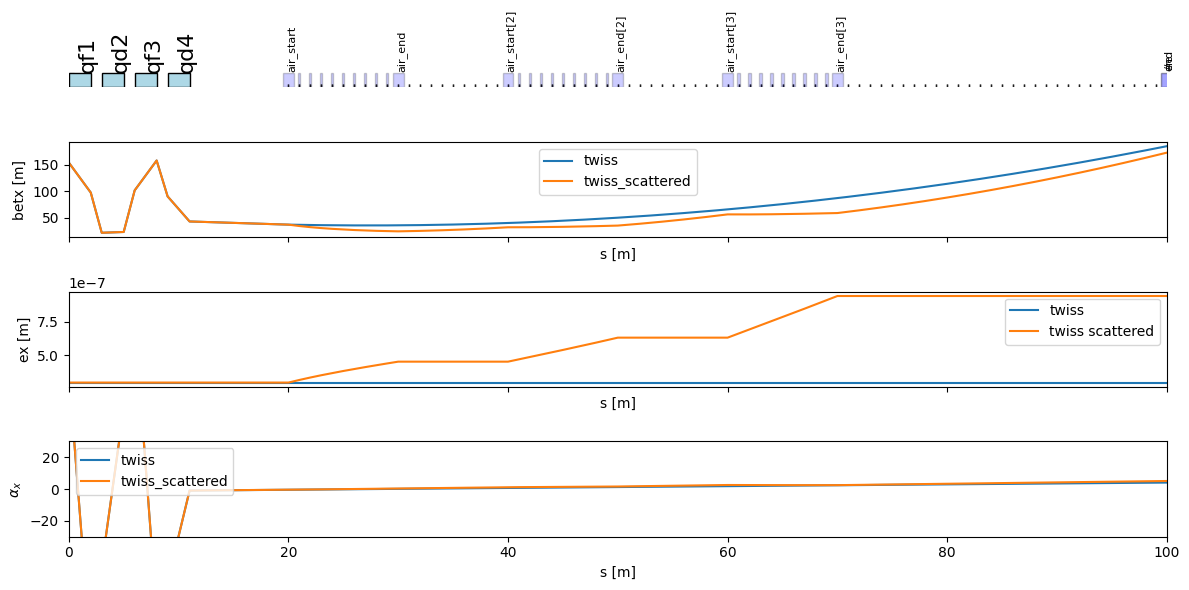

In [28]:
fig, ax = plt.subplots(4,1, figsize=(12, 6), sharex=True, height_ratios=[1, 4, 4, 4], tight_layout=True)
draw_synoptic(ax[0], twiss)
ax[1].plot(twiss.s, twiss.betx, label='twiss')
ax[1].plot(twiss_scattered.s, twiss_scattered.betx, label='twiss_scattered')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('betx [m]')
ax[1].legend()

ax[2].plot(twiss.s, twiss.ex, label='twiss')
ax[2].plot(twiss_scattered.s, twiss_scattered.ex, label='twiss scattered')
ax[2].set_xlabel('s [m]')
ax[2].set_ylabel('ex [m]')
ax[2].legend()

ax[3].plot(twiss.s, -2*twiss.alfx, label='twiss')
ax[3].plot(twiss_scattered.s, -2*twiss_scattered.alfx, label='twiss_scattered')
ax[3].set_xlabel('s [m]')
ax[3].set_ylabel(r'$\alpha_{x}$')
ax[3].set_ylim(-30, 30)
ax[3].legend()

In [29]:
fig, ax = plt.subplots(4,1, figsize=(12, 6), sharex=True, height_ratios=[1, 4, 4, 4], tight_layout=True)
draw_synoptic(ax[0], twiss)
ax[1].plot(twiss.s, twiss.bety, label='twiss')
ax[1].plot(twiss_scattered.s, twiss_scattered.bety, label='twiss_scattered')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('bety [m]')
ax[1].legend()

ax[2].plot(twiss.s, twiss.ey, label='twiss')
ax[2].plot(twiss_scattered.s, twiss_scattered.ey, label='twiss scattered')
ax[2].set_xlabel('s [m]')
ax[2].set_ylabel('ey [m]')
ax[2].legend()

ax[3].plot(twiss.s, -2*twiss.alfy, label='twiss')
ax[3].plot(twiss_scattered.s, -2*twiss_scattered.alfy, label='twiss_scattered')
ax[3].set_xlabel('s [m]')
ax[3].set_ylabel(r'$\alpha_{y}$')
ax[3].set_ylim(-30, 30)
ax[3].legend()

In [33]:
fig, ax = plt.subplots(2,1 ,figsize=(12, 4), sharex=True, height_ratios=[1, 4])

draw_synoptic(ax[0], twiss_scattered)

ax[1].plot(twiss.s, 1000*beam_size(twiss.betx, twiss.dx, twiss.ex, sige, 1), label='vaccum', ls="--")
ax[1].plot(twiss_scattered.s, 1000*beam_size(twiss_scattered.betx, twiss_scattered.dx, twiss_scattered.ex, sige, 1), label='scattered')

ax[1].plot(twiss.s, 1000*beam_size(twiss.bety, twiss.dy, twiss.ey, sige, 1), label='vaccum V', ls="--")
ax[1].plot(twiss_scattered.s, 1000*beam_size(twiss_scattered.bety, twiss_scattered.dy, twiss_scattered.ey, sige, 1), label='scattered V')

ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('Beam size [mm]')
ax[1].legend()

In [31]:
beam_size_end_no_scattered = 1000*beam_size(twiss.loc["end"].betx, twiss.loc["end"].dx, twiss.loc["end"].ex, sige, 1)
beam_size_end_scattered = 1000*beam_size(twiss_scattered.loc["end"].betx, twiss_scattered.loc["end"].dx, twiss_scattered.loc["end"].ex, sige, 1)

print(f"Beam size at the end is {round(beam_size_end_no_scattered,1)} mm")
print(f"Beam size scattered at the end is {round(beam_size_end_scattered,1)} mm")
print(f"Beam size increase is {round(100*beam_size_end_scattered/beam_size_end_no_scattered,1) - 100 } %")

Beam size at the end is 7.5 mm
Beam size scattered at the end is 12.8 mm
Beam size increase is 70.0 %


In [32]:
print(f"alfx analytical before = {round(twiss.loc['end'].alfx,2)} after = {round(twiss_scattered.loc['end'].alfx,2)}")
print(f"betx analytical before = {round(twiss.loc['end'].betx,2)} after = {round(twiss_scattered.loc['end'].betx,2)}")
print(f"ex analytical before = {round(twiss.loc['end'].ex,9)} after = {round(twiss_scattered.loc['end'].ex,9)}")


alfx analytical before = -2.06 after = -2.55
betx analytical before = 185.0 after = 172.8
ex analytical before = 2.99e-07 after = 9.42e-07
